In [42]:
from run import wav_read
from run import init_convtasnet, init_dprnntasnet
import numpy as np
import pandas as pd
import os, pathlib

Verification that no normalization is needed (`max_val<=1`).

In [10]:
max_val = -1
for f in pathlib.Path('/data/asivara/librispeech/').rglob('*.wav'):
    v = np.max(np.abs(wav_read(f)))
    max_val = max(max_val, v)
print(max_val)

1.0


Make a dataframe for all of Librispeech.

In [4]:
from run import load_librispeech, load_demand
librispeech = load_librispeech('/data/asivara/librispeech/')
demand = load_demand('/data/asivara/demand/')
print(librispeech)
print(demand)

              subset_id  speaker_id  chapter_id  utterance_id  \
0             dev-clean        1272      128104             0   
1             dev-clean        1272      128104             1   
2             dev-clean        1272      128104             2   
3             dev-clean        1272      128104             3   
4             dev-clean        1272      128104             4   
...                 ...         ...         ...           ...   
137871  train-clean-360         986      129388           108   
137872  train-clean-360         986      129388           109   
137873  train-clean-360         986      129388           110   
137874  train-clean-360         986      129388           111   
137875  train-clean-360         986      129388           112   

                                                 filepath  duration  
0       /data/asivara/librispeech/dev-clean/1272/12810...     5.855  
1       /data/asivara/librispeech/dev-clean/1272/12810...     4.815  
2       /

In [46]:
import pathlib
import pandas as pd

dataset_directory: str = '/data/asivara/fsd50k_16khz/'
dataset_directory = pathlib.Path(dataset_directory)

# merge separate dev and eval sets into one big table
df1 = pd.read_csv(next(dataset_directory.rglob('dev.csv')))
df2 = pd.read_csv(next(dataset_directory.rglob('eval.csv')))
df2['split'] = 'test'
df = pd.concat([df1, df2])

# omit sounds labeled as containing speech or music
df['labels'] = df['labels'].apply(str.lower)
df = df[~df['labels'].str.contains('speech')]
df = df[~df['labels'].str.contains('music')]

durations, filepaths = [], []
for row in df.itertuples():
    if row.split == 'test':
        filepath = dataset_directory.joinpath('FSD50K.eval_audio', str(row.fname)+'.wav')
    else:
        filepath = dataset_directory.joinpath('FSD50K.dev_audio', str(row.fname)+'.wav')
    assert filepath.exists()
    duration = len(wav_read(filepath)) / 16000
    durations.append(duration)
    filepaths.append(filepath)
df['filepath'] = filepaths
df['duration'] = durations
del df['mids']

3    cafeter
4    traffic
5       park
6    washing
Name: location_id, dtype: object

In [379]:
import importlib, run
importlib.reload(run)
from run import load_librispeech, load_fsd50k, load_demand, wav_read
from run import wav_read_multiple, mix_signals, sisdr, sisdr_improvement
from typing import Union, Tuple

def get_personalized_dataset(test_speaker: Union[int, str],
                             environment_snr_db: Union[float, Tuple[float, float]],
                             num_environments: int = 1):

    # build test set
    rng = np.random.default_rng(0)

    # retrieve datasets
    S_te = load_librispeech().query('subset_id == "test-clean"')
    S_te = S_te[['speaker_id', 'filepath', 'duration']]
    test_speakers = S_te['speaker_id'].unique()
    if test_speaker not in test_speakers:
        raise ValueError(f'Invalid test speaker ID: {test_speaker}.')
    M = load_demand()
    
    # map each speaker to one or multiple environments
    if num_environments < 1 or not isinstance(num_environments, int):
        raise ValueError('Expected non-zero integer number of environments.')
    elif num_environments > len(M):
        raise ValueError(f'Maximum test-time environments is {len(M)}.')
    elif num_environments == 1:
        test_envs = rng.permutation(len(test_speakers)) % len(M)
        env_mapping = {k: v for (k, v) in zip(test_speakers, test_envs)}
    else:
        n = num_environments
        test_envs = rng.permutation(len(test_speakers)*n) % len(M)
        env_mapping = {k: list(test_envs[i:i+n])
                       for (i, k) in enumerate(test_speakers)}

    # each test speaker in LibriSpeech has at least 300 seconds
    # of utterance data to work with. split their data as follows:
    # - test set = 30 seconds
    # - validation set = 30 seconds
    # - finetune set = 60 seconds
    # - train set = remainder
    utterance_list = S_te.query('speaker_id == @test_speaker')
    utterance_list = utterance_list.sort_values('duration').reset_index()
    utterance_list['cumsum'] = utterance_list['duration'].cumsum()
    split_te = (utterance_list['cumsum']-30).abs().idxmin()
    split_vl = (utterance_list['cumsum']-60).abs().idxmin()
    split_ft = (utterance_list['cumsum']-120).abs().idxmin()
    u_te = utterance_list.iloc[0:split_te]
    u_vl = utterance_list.iloc[split_te:split_vl]
    u_ft = utterance_list.iloc[split_vl:split_ft]
    u_tr = utterance_list.iloc[split_ft:]

    # load all the speaker audio and concatenate it into a
    # single long vector
    s_te = np.concatenate([wav_read(f) for f in u_te.filepath])
    s_vl = np.concatenate([wav_read(f) for f in u_vl.filepath])
    s_ft = np.concatenate([wav_read(f) for f in u_ft.filepath])
    s_tr = np.concatenate([wav_read(f) for f in u_tr.filepath])
    s = np.concatenate([s_te, s_vl, s_ft, s_tr])

    # load the premixture noise profile
    env_indices = env_mapping[test_speaker]
    if num_environments == 1:
        p = wav_read(M.iloc[env_indices]['filepath'])
    else:
        p = np.stack([wav_read(f) for f in
                      M.iloc[env_indices]['filepath']])

    # segment the premixture noise similarly
    split_te = len(s_te)
    split_vl = split_te + len(s_vl)
    split_ft = split_vl + len(s_ft)
    p_te = p[..., 0:split_te]
    p_vl = p[..., split_te:split_vl]
    p_ft = p[..., split_vl:split_ft]
    p_tr = p[..., split_ft:]

    # circularly loop the training premixture noise if it is
    # too short
    tile_count = -(-s_tr.shape[-1]//p_tr.shape[-1])
    if num_environments == 1:
        p_tr = np.tile(p_tr, tile_count)
    else:
        p_tr = np.tile(p_tr, (1, tile_count))
    p_tr = p_tr[..., :len(s_tr)]
    p = np.concatenate([p_te, p_vl, p_ft, p_tr], axis=-1)

    # get the correct mixing scalar based on the overall
    # energies of the speech and premixture datasets
    energy_s = np.sum(s**2, axis=-1, keepdims=True)
    energy_n = np.sum(p**2, axis=-1, keepdims=True)
    snr_db = np.mean(environment_snr_db)
    b = np.sqrt((energy_s/energy_n)*(10**(-snr_db/10.)))

    # combine all the signals
    x_te = s_te + b*p_te

    return {
        'train_speech': s_tr,
        'train_prenoise': p_tr,
        'finetune_speech': s_ft,
        'val_speech': s_vl,
        'val_prenoise': p_vl,
        'test_speech': s_te,
        'test_prenoise': p_te,
        'test_premixture': x_te,
        'environments': {i: j for (i, j) in enumerate(
            M.iloc[env_indices]['location_id'])}
    }

In [376]:
M

category_id location_id                                filepath  \
0         domestic      living   /data/asivara/demand/DLIVING/ch01.wav   
1           office     hallway  /data/asivara/demand/OHALLWAY/ch01.wav   
2           office      office   /data/asivara/demand/OOFFICE/ch01.wav   
3           public     cafeter  /data/asivara/demand/PCAFETER/ch01.wav   
4           street     traffic  /data/asivara/demand/STRAFFIC/ch01.wav   
5           nature        park     /data/asivara/demand/NPARK/ch01.wav   
6         domestic     washing  /data/asivara/demand/DWASHING/ch01.wav   
7   transportation         bus      /data/asivara/demand/TBUS/ch01.wav   
8           public       resto    /data/asivara/demand/PRESTO/ch01.wav   
9           office     meeting  /data/asivara/demand/OMEETING/ch01.wav   
10  transportation       metro    /data/asivara/demand/TMETRO/ch01.wav   
11          public     station  /data/asivara/demand/PSTATION/ch01.wav   
12          nature       field    /data/asivara/demand/NFIELD/ch01.wav   
13        domestic     kitchen  /data/asivara/demand/DKITCHEN/ch01.wav   
14          nature       river    /data/asivara/demand/NRIVER/ch01.wav   
15  transportation         car      /data/asivara/demand/TCAR/ch01.wav   
16          street     psquare  /data/asivara/demand/SPSQUARE/ch01.wav   

    duration  
0    300.004  
1    300.004  
2    300.004  
3    300.004  
4    300.004  
5    300.004  
6    300.004  
7    300.004  
8    300.004  
9    300.004  
10   300.004  
11   300.004  
12   300.004  
13   300.004  
14   300.004  
15   300.004  
16   300.004

In [381]:
d = get_personalized_dataset(1320, 0, 4)
print(d['environments'])
for _ in range(len(d['environments'])):
    ipd.display(ipd.Audio(d['test_premixture'][_], rate=16000))

{0: 'car', 1: 'bus', 2: 'hallway', 3: 'living'}


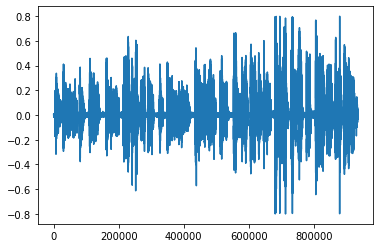

In [254]:
import matplotlib.pyplot as plt
import IPython.display as ipd
plt.plot(s_ft[np.abs(s_ft) < .8])
ipd.display(ipd.Audio(s_ft[np.abs(s_ft) < .8], rate=16000))

In [182]:
env_mapping

{2094: 11,
 7127: 10,
 8230: 4,
 260: 7,
 1221: 6,
 3570: 2,
 8455: 3,
 3729: 0,
 7021: 1,
 5683: 1,
 7729: 10,
 672: 5,
 1284: 3,
 6930: 9,
 1188: 11,
 61: 13,
 4446: 3,
 1995: 4,
 1320: 0,
 2830: 0,
 8224: 4,
 1580: 1,
 7176: 9,
 908: 6,
 1089: 15,
 8463: 8,
 237: 2,
 121: 2,
 2300: 8,
 4992: 16,
 4970: 13,
 5105: 12,
 2961: 7,
 4507: 5,
 5142: 5,
 4077: 14,
 5639: 12,
 8555: 16,
 3575: 15,
 6829: 14}

In [133]:
M = load_demand()
M

category_id location_id                                filepath  \
0         domestic      living   /data/asivara/demand/DLIVING/ch01.wav   
1           office     hallway  /data/asivara/demand/OHALLWAY/ch01.wav   
2           office      office   /data/asivara/demand/OOFFICE/ch01.wav   
3           public     cafeter  /data/asivara/demand/PCAFETER/ch01.wav   
4           street     traffic  /data/asivara/demand/STRAFFIC/ch01.wav   
5           nature        park     /data/asivara/demand/NPARK/ch01.wav   
6         domestic     washing  /data/asivara/demand/DWASHING/ch01.wav   
7   transportation         bus      /data/asivara/demand/TBUS/ch01.wav   
8           public       resto    /data/asivara/demand/PRESTO/ch01.wav   
9           office     meeting  /data/asivara/demand/OMEETING/ch01.wav   
10  transportation       metro    /data/asivara/demand/TMETRO/ch01.wav   
11          public     station  /data/asivara/demand/PSTATION/ch01.wav   
12          nature       field    /data/asivara/demand/NFIELD/ch01.wav   
13        domestic     kitchen  /data/asivara/demand/DKITCHEN/ch01.wav   
14          nature       river    /data/asivara/demand/NRIVER/ch01.wav   
15  transportation         car      /data/asivara/demand/TCAR/ch01.wav   
16          street     psquare  /data/asivara/demand/SPSQUARE/ch01.wav   

    duration  
0    300.004  
1    300.004  
2    300.004  
3    300.004  
4    300.004  
5    300.004  
6    300.004  
7    300.004  
8    300.004  
9    300.004  
10   300.004  
11   300.004  
12   300.004  
13   300.004  
14   300.004  
15   300.004  
16   300.004

In [97]:
x_batch = mix_signals(s_batch, n_batch, 0)

In [102]:
sisdr_improvement(x_batch[0:2], s_batch[0:2], x_batch[0:2]).mean()

tensor(-103.0440)

In [73]:
_rng = np.random.default_rng(0)
config = dict(mixture_snr=(-5,5))
_batch_size, num_batches = 12, 5

In [76]:
# circularly index the datasets
indices = np.arange(_batch_size * num_batches,
    _batch_size * (num_batches + 1), 1)
s = wav_read_multiple(S_tr.filepath[indices % len(S_tr)])
n = wav_read_multiple(N_tr.filepath[indices % len(N_tr)])

# mix the signals up at random snrs
snrs = _rng.uniform(low=config['mixture_snr'][0],
                    high=config['mixture_snr'][1],
                    size=(_batch_size, 1))
x = mix_signals(s, n, snrs)

In [80]:
s.shape == x.shape

True

In [81]:
# pick up dataset splits
S = load_librispeech()
S_tr = S.query('subset_id == "train-clean-100"')
S_vl = S.query('subset_id == "dev-clean"')
S_te = S.query('subset_id == "test-clean"')
N = load_fsd50k()
N_tr = N.query('split == "train"')
N_vl = N.query('split == "val"')
N_te = N.query('split == "test"')

In [83]:
N_vl

fname                                             labels split  \
13339  108268  drawer_open_or_close,domestic_sounds_and_home_...   val   
13340  316689                       train,rail_transport,vehicle   val   
13341  388915             typing,domestic_sounds_and_home_sounds   val   
13342  254834                                fireworks,explosion   val   
13343  434393                             drill,power_tool,tools   val   
...       ...                                                ...   ...   
15263  376599  drawer_open_or_close,domestic_sounds_and_home_...   val   
15264   45435                                            crackle   val   
15265  233586  dishes_and_pots_and_pans,chink_and_clink,domes...   val   
15266   72223                    thunder,rain,water,thunderstorm   val   
15267  361551        applause,crowd,cheering,human_group_actions   val   

                                                filepath   duration  
13339  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/10...  18.517375  
13340  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/31...   4.330312  
13341  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/38...  18.922625  
13342  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/25...  23.939250  
13343  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/43...  17.842750  
...                                                  ...        ...  
15263  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/37...  12.549312  
15264  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/45...  22.897313  
15265  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/23...   7.000000  
15266  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/72...  25.302375  
15267  /data/asivara/fsd50k_16khz/FSD50K.dev_audio/36...   8.295000  

[1929 rows x 5 columns]

In [125]:
import importlib, run
importlib.reload(run)
from run import train_sup
train_sup(dict(training_procedure='sup',
               learning_rate=1e-3, model_name='grunet', model_size='small', mixture_snr=(-5,5)))

KeyboardInterrupt: 

camera,mechanisms


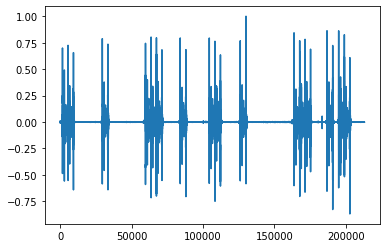

hammer,tools


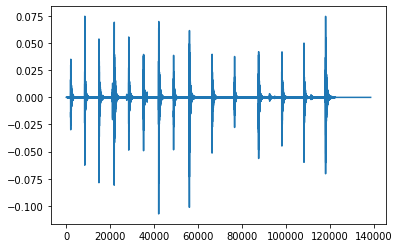

cough,respiratory_sounds


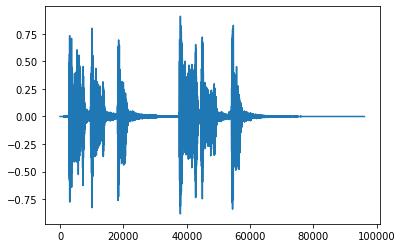

engine_starting,accelerating_and_revving_and_vroom,motor_vehicle_(road),vehicle,engine


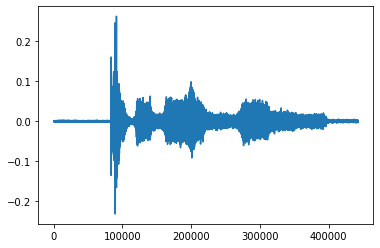

In [69]:
import IPython.display as ipd
import matplotlib.pyplot as plt
for r in df[~df['labels'].str.contains('music')].query('duration >= 4').sample(frac=1, random_state=2)[:4].itertuples():
    filepath = r.filepath
    print(r.labels)
    s = wav_read(filepath)
    plt.plot(s)
    plt.show()
    ipd.display(ipd.Audio(s, rate=16000))